Training MAML...
MAML Epoch 0, Loss: 0.6891
MAML Epoch 500, Loss: 0.3877
MAML Epoch 1000, Loss: 0.7207
MAML Epoch 1500, Loss: 0.3513

Training Baseline...
Baseline Epoch 0, Loss: 0.7339
Baseline Epoch 500, Loss: 0.4083
Baseline Epoch 1000, Loss: 0.2610
Baseline Epoch 1500, Loss: 0.2935


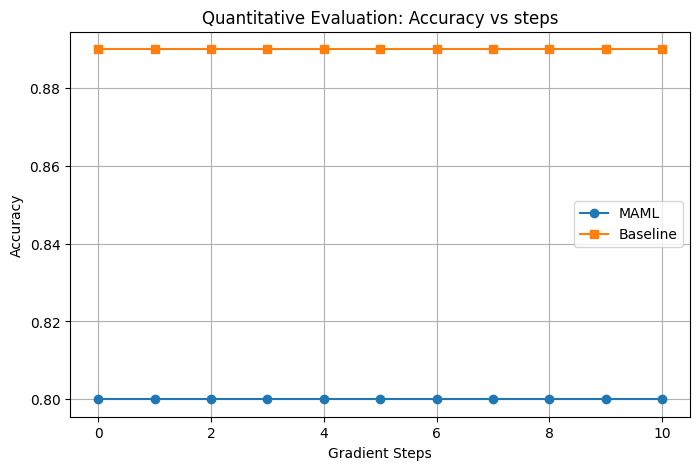

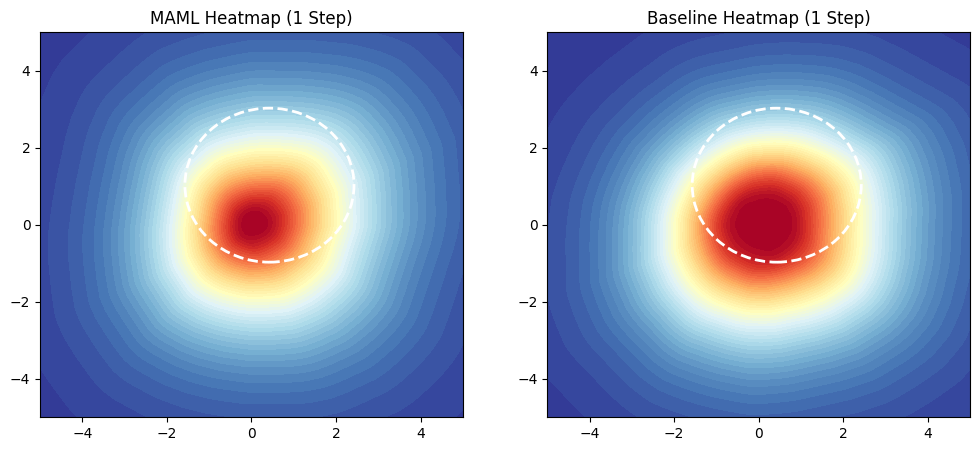

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import copy

# --- 1. DATASET GENERATION [cite: 4, 7, 8, 11] ---
def generate_task():

    center = np.random.uniform(-3, 3, size=2) # [cite: 8]
    radius = 2.0 # [cite: 8]
    return center, radius

def sample_data(center, radius, num_samples):

    # Input Space: x in [-5, 5] [cite: 7]
    x = np.random.uniform(-5, 5, size=(num_samples, 2))
    # Labels: 1 if inside circle, 0 otherwise [cite: 11]
    dist = np.sqrt(np.sum((x - center)**2, axis=1))
    y = (dist < radius).astype(np.float32).reshape(-1, 1)
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

#  MODEL ARCHITECTURE [cite: 16]
class MAMLNet(nn.Module):
    def __init__(self):
        super(MAMLNet, self).__init__()
        # Manual parameter definition to allow functional forward pass
        self.w1 = nn.Parameter(torch.randn(64, 2) * 0.1)
        self.b1 = nn.Parameter(torch.zeros(64))
        self.w2 = nn.Parameter(torch.randn(64, 64) * 0.1)
        self.b2 = nn.Parameter(torch.zeros(64))
        self.w3 = nn.Parameter(torch.randn(1, 64) * 0.1)
        self.b3 = nn.Parameter(torch.zeros(1))

    def forward(self, x, weights=None):
        if weights is None:
            w1, b1, w2, b2, w3, b3 = self.w1, self.b1, self.w2, self.b2, self.w3, self.b3
        else:
            w1, b1, w2, b2, w3, b3 = weights

        x = F.linear(x, w1, b1)
        x = F.relu(x)
        x = F.linear(x, w2, b2)
        x = F.relu(x)
        x = F.linear(x, w3, b3)
        return torch.sigmoid(x)

#  MAML IMPLEMENTATION [cite: 15, 18, 19, 20]
def maml_train(model, epochs=2000, lr_inner=0.01, lr_outer=0.001, k_shot=10):
    optimizer = optim.Adam(model.parameters(), lr=lr_outer)
    criterion = nn.BCELoss()

    for epoch in range(epochs):
        center, radius = generate_task()
        x_s, y_s = sample_data(center, radius, k_shot) # Support Set [cite: 12]
        x_q, y_q = sample_data(center, radius, k_shot) # Query Set

        # Inner Loop: 1 gradient step [cite: 19]
        preds_s = model(x_s)
        inner_loss = criterion(preds_s, y_s)
        grads = torch.autograd.grad(inner_loss, model.parameters(), create_graph=True)

        # Fast Weights calculation (Functional)
        fast_weights = [p - lr_inner * g for p, g in zip(model.parameters(), grads)]

        # Outer Loop: Meta-Update
        preds_q = model(x_q, weights=fast_weights)
        outer_loss = criterion(preds_q, y_q)

        optimizer.zero_grad()
        outer_loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"MAML Epoch {epoch}, Loss: {outer_loss.item():.4f}")

#  BASELINE (JOINT TRAINING) [cite: 22, 23, 24]
def baseline_train(model, epochs=2000, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    for epoch in range(epochs):
        # Sample points from random tasks simultaneously [cite: 23]
        center, radius = generate_task()
        x_batch, y_batch = sample_data(center, radius, 32)

        optimizer.zero_grad()
        loss = criterion(model(x_batch), y_batch)
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Baseline Epoch {epoch}, Loss: {loss.item():.4f}")

#  EVALUATION AND PLOTTING [cite: 28, 29, 30, 32, 33]
def evaluate_steps(model, center, radius, steps=10, lr=0.01, k_shot=10):
    x_s, y_s = sample_data(center, radius, k_shot)
    x_test, y_test = sample_data(center, radius, 100)

    # We must use the functional approach even for evaluation to be consistent
    accuracies = []

    # Initial weights
    current_weights = [p.clone() for p in model.parameters()]

    for step in range(steps + 1):
        with torch.no_grad():
            preds = (model(x_test, weights=current_weights) > 0.5).float()
            acc = (preds == y_test).float().mean().item()
            accuracies.append(acc)

        if step < steps:
            # Manual GD step for fine-tuning
            preds_s = model(x_s, weights=current_weights)
            loss = F.binary_cross_entropy(preds_s, y_s)
            grads = torch.autograd.grad(loss, current_weights)
            current_weights = [w - lr * g for w, g in zip(current_weights, grads)]

    return accuracies

#  RUN TRAINING
maml_model = MAMLNet()
baseline_model = MAMLNet()

print("Training MAML...")
maml_train(maml_model)

print("\nTraining Baseline...")
baseline_train(baseline_model)

# --- GENERATE PLOTS ---
test_c, test_r = generate_task()
maml_accs = evaluate_steps(maml_model, test_c, test_r)
base_accs = evaluate_steps(baseline_model, test_c, test_r)

# 1. Quantitative Evaluation Plot [cite: 28, 29]
plt.figure(figsize=(8, 5))
plt.plot(range(11), maml_accs, label='MAML', marker='o')
plt.plot(range(11), base_accs, label='Baseline', marker='s')
plt.xlabel("Gradient Steps")
plt.ylabel("Accuracy")
plt.title("Quantitative Evaluation: Accuracy vs steps")
plt.legend()
plt.grid(True)
plt.show()

# 2. Qualitative Visualization (Heatmaps) [cite: 32, 33, 35, 36]
def get_heatmap(model, weights, ax, center, radius, title):
    side = np.linspace(-5, 5, 100)
    x1, x2 = np.meshgrid(side, side)
    x_grid = torch.tensor(np.c_[x1.ravel(), x2.ravel()], dtype=torch.float32)
    with torch.no_grad():
        probs = model(x_grid, weights=weights).reshape(100, 100).numpy()

    ax.contourf(x1, x2, probs, levels=50, cmap='RdYlBu_r')
    circle = plt.Circle(center, radius, color='white', fill=False, linestyle='--', linewidth=2)
    ax.add_patch(circle)
    ax.set_title(title)

# Prepare 1-step weights
x_s, y_s = sample_data(test_c, test_r, 10)
def get_1_step(mod):
    w = [p.clone() for p in mod.parameters()]
    l = F.binary_cross_entropy(mod(x_s, weights=w), y_s)
    g = torch.autograd.grad(l, w)
    return [wi - 0.01 * gi for wi, gi in zip(w, g)]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
get_heatmap(maml_model, get_1_step(maml_model), axes[0], test_c, test_r, "MAML Heatmap (1 Step)")
get_heatmap(baseline_model, get_1_step(baseline_model), axes[1], test_c, test_r, "Baseline Heatmap (1 Step)")
plt.show()